In [82]:
import gym
import numpy as np
import real_market_env_gym

from collections import namedtuple, deque

import torch
import torch.nn as nn
import copy

import random

import matplotlib
import matplotlib.pyplot as plt

from itertools import count

from tqdm import tqdm

from stock_data import generate_prices

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

### Agent setup for deep Q-learning

In [83]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cpu


In [84]:
model = nn.Sequential(
    nn.Linear(102, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 3),
    nn.Softmax(dim=1)
)

#### Setup replay memory

In [85]:
transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory:
    def __init__(self, maxlen=None) -> None:
        self.memory = deque([], maxlen=maxlen)
    
    def push(self, *args):
        self.memory.append(transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


### Env setup

In [86]:
env = gym.make('rand_market_env_gym-v0')

# RANDOM_SEED = 42
# torch.manual_seed(RANDOM_SEED)
# np.random.seed(RANDOM_SEED)

print(f"action space: {env.action_space}")
print(f"observation space: {env.observation_space}")

action space: Discrete(3)
observation space: Box(0.0, 1000000000.0, (102,), float64)


### Setup training hyperparameters and helper/callback functions

In [87]:
BATCH_SIZE = 16
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TAU = 5e-3
LR = 1e-4

n_actions = env.action_space.n
state, info = env.reset()

n_states = len(state)

print(f"n_actions: {n_actions}")
print(f"n_states: {n_states}")

policy = copy.deepcopy(model).to(DEVICE)
# policy = torch.load('log/policy.pth').to(DEVICE)
target = copy.deepcopy(model).to(DEVICE)
target.load_state_dict(policy.state_dict())

# for some reason, use adamw, which is adam with weight decay
optimizer = torch.optim.Adam(policy.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps = 0

n_actions: 3
n_states: 102


In [88]:
def _get_eps_threshold(steps):
    return EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps / EPS_DECAY)

In [89]:
def select_action(state):
    global steps
    sample = random.random()
    eps_threshold = _get_eps_threshold(steps)
    steps += 1

    if sample > eps_threshold:
        return policy(state).argmax().view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=DEVICE, dtype=torch.long)

### Finally, training

In [90]:
def optimize_step():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # converts batch array of transitions to transition of batch arrays
    batch = transition(*zip(*transitions))

    # get only the non-final states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=DEVICE, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state).view(BATCH_SIZE, -1)
    action_batch = torch.cat(batch.action).view(BATCH_SIZE, -1)
    reward_batch = torch.cat(batch.reward).view(BATCH_SIZE, -1)

    state_action_values = policy(state_batch).gather(1, action_batch).view(BATCH_SIZE, -1)
    next_state_values = torch.zeros(BATCH_SIZE, device=DEVICE)
    with torch.no_grad():
        non_final_next_states = non_final_next_states.view(next_state_values[non_final_mask].shape[0], -1)
        next_state_values[non_final_mask] = target(non_final_next_states).max(1)[0].detach()
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # huber loss
    func = nn.SmoothL1Loss()
    loss = func(state_action_values, expected_state_action_values.unsqueeze(0))

    optimizer.zero_grad()
    loss.backward()

    nn.utils.clip_grad_value_(policy.parameters(), 100)
    optimizer.step()


In [91]:
episode_returns = []

real_episodes = 1000

In [93]:
env = gym.make('real_market_env_gym-v0')
for ep in tqdm(range(real_episodes), desc='Training real', position=0):

    state, info = env.reset()
    state = torch.tensor(state, device=DEVICE, dtype=torch.float)

    for i in range(100):
        action = select_action(state)
        next_state, reward, term, trunc, info = env.step(action.item())
        reward = torch.tensor([reward], device=DEVICE, dtype=torch.float)

        if not (term or trunc):
            next_state = torch.tensor(next_state, device=DEVICE, dtype=torch.float)
        else:
            next_state = None
        
        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_step()

        target_dict = target.state_dict()
        policy_dict = policy.state_dict()

        for key in policy_dict:
            target_dict[key] = TAU * policy_dict[key] + (1.0 - TAU) * target_dict[key]
        target.load_state_dict(target_dict)

        if term or trunc:
            episode_returns.append(info['value'])
            break

Training real: 100%|██████████| 1000/1000 [03:48<00:00,  4.37it/s]


In [94]:
torch.save(policy, 'log/policy.pth')
# print(policy.state_dict())

### Testing

In [95]:
test_returns = []
test_growth = []

policy = torch.load('log/policy.pth').to(DEVICE)
test_episodes = 100

gen_data = []
gen_growth = []

env = gym.make('real_market_env_gym-v0')

for ep in tqdm(range(test_episodes), desc='Testing', position=0):
    state, info = env.reset(training=False)
    state = torch.tensor(state, device=DEVICE, dtype=torch.float)

    for i in range(100):
        action = policy(state).argmax().view(1, 1)
        next_state, reward, term, trunc, info = env.step(action.item())
        reward = torch.tensor([reward], device=DEVICE, dtype=torch.float)

        if not (term or trunc):
            next_state = torch.tensor(next_state, device=DEVICE, dtype=torch.float)
        else:
            next_state = None
        
        state = next_state

        if term or trunc:
            gen_data.append((info['end'] - info['start']) * info['assets'])
            gen_growth.append((info['end'] / info['start']) - 1)
            test_returns.append(info['value'])
            test_growth.append((info['value'] / 1000) - 1)
            break
    

Testing: 100%|██████████| 100/100 [00:02<00:00, 45.78it/s]


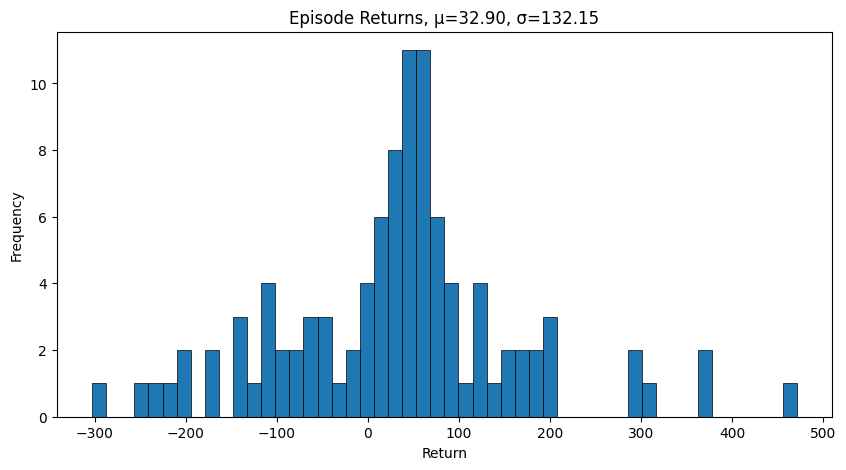

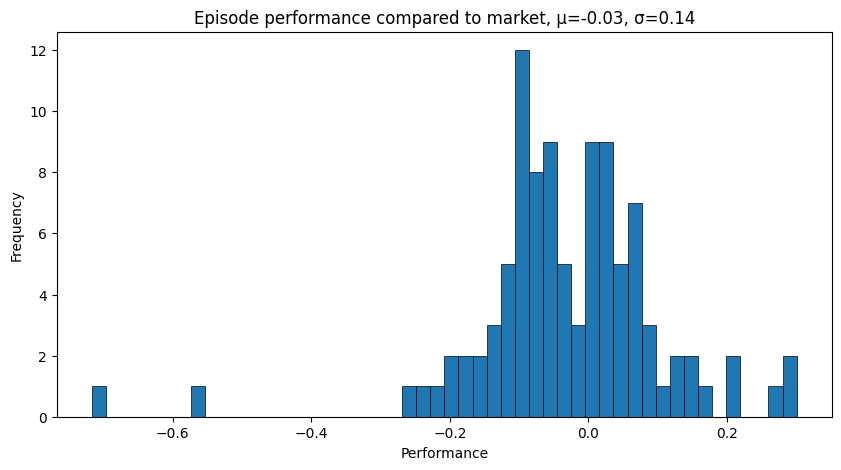

Profitability: 31|0|69
Performance: 56|0|44


In [96]:
data = np.array(test_returns)
market = np.array(gen_data)

data -= 1000
data = data[~np.isnan(data)]

data2 = np.array(test_growth) - np.array(gen_growth)
data2 = data2[~np.isnan(data2)]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.hist(data, bins=50, edgecolor='black', linewidth=0.5)

mean = data.mean()
std = data.std()

ax1.set_title(f'Episode Returns, µ={mean:.2f}, σ={std:.2f}')
ax1.set_xlabel('Return')
ax1.set_ylabel('Frequency')

fig, ax2 = plt.subplots(1, 1, figsize=(10, 5))
ax2.hist(data2, bins=50, edgecolor='black', linewidth=0.5)

mean2 = data2.mean()
std2 = data2.std()

ax2.set_title(f'Episode performance compared to market, µ={mean2:.2f}, σ={std2:.2f}')
ax2.set_xlabel('Performance')
ax2.set_ylabel('Frequency')

plt.show()

print(f'Profitability: {len(data[data < 0])}|{len(data[data == 0])}|{len(data[data > 0])}')
print(f'Performance: {len(data2[data2 < 0])}|{len(data2[data2 == 0])}|{len(data2[data2 > 0])}')

In [97]:
# print(data)
# print(data2)